In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/Amazon_Products.csv")

data.dropna(subset=['Body'], inplace=True)
data.dropna(subset=['Title'], inplace=True)

data.head(5)


Mounted at /content/drive


,ASIN,Product,Title,Rating,Date,Body,Brand
0,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Great product,5,22 February 2020,This is a brilliant product...I'd had the Tefa...,Princess
1,B0741D7LRD,"Princess 182050 Digital air Fryer, Black","I love mine, pity the non stick coating comes ...",1,25 June 2019,"I love mine, pity the non stick coating comes ...",Princess
2,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Digital programming broke down,1,21 March 2019,Thought this product would be great but had it...,Princess
3,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Perfect,5,4 July 2022,This is my second one of these the 1st lasted ...,Smartwares
4,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Great item,5,22 February 2022,Great item,Smartwares


In [ ]:
data['Sentiment'] = data['Rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
data['Text'] = data['Body'] + data['Title']
data['id'] = np.arange(data.shape[0])
data.head(5)

,ASIN,Product,Title,Rating,Date,Body,Brand,Sentiment,Text,id
0,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Great product,5,22 February 2020,This is a brilliant product...I'd had the Tefa...,Princess,positive,This is a brilliant product...I'd had the Tefa...,0
1,B0741D7LRD,"Princess 182050 Digital air Fryer, Black","I love mine, pity the non stick coating comes ...",1,25 June 2019,"I love mine, pity the non stick coating comes ...",Princess,negative,"I love mine, pity the non stick coating comes ...",1
2,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Digital programming broke down,1,21 March 2019,Thought this product would be great but had it...,Princess,negative,Thought this product would be great but had it...,2
3,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Perfect,5,4 July 2022,This is my second one of these the 1st lasted ...,Smartwares,positive,This is my second one of these the 1st lasted ...,3
4,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Great item,5,22 February 2022,Great item,Smartwares,positive,Great itemGreat item,4


In [ ]:
data.isnull().values.any()

False

<Axes: xlabel='Sentiment', ylabel='count'>

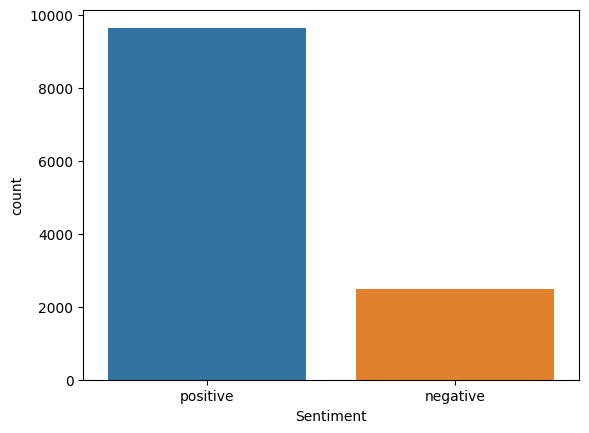

In [ ]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='Sentiment', data=data)

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(data['Text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
y = data['Sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X

['brilliant product tefal actifry previously godsend oven brokegreat product',
 'love mine pity non stick coating comes cooks well good quality let non stick scratching easily updated one star cannot find spare basketi love mine pity non stick coating comes buy replacement',
 'thought product would great weeks digital program working already gona go backdigital programming broke ',
 'second one st lasted years well happyperfect',
 'great itemgreat item',
 'instruction manual hard understand like prong plug arrive cook book stated website returned nd january still heard anything even though requested phone call disappointed easy explain instruction manual ',
 'simply anything airfryer love itthis simply best',
 'great product juicer',
 'need small cup lemons limes mandarines ect half citrus placed place let vidrating',
 'good value money deep creases freatgood buy',
 'firstly fitted pronged plug disappointing plugged nothing happened would even switch work faultu',
 'arrived broken impr

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

In [ ]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

9136

In [ ]:
# Padding all reviews to fixed length 200

maxlen = 500

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(9136, 100)

In [ ]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 100)          913600    
                                                                 
 flatten_2 (Flatten)         (None, 50000)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 50001     
                                                                 
Total params: 963,601
Trainable params: 50,001
Non-trainable params: 913,600
_________________________________________________________________
None


In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
61/61 [==============================] - 1s 6ms/step - loss: 0.6815 - acc: 0.7876 - val_loss: 0.6712 - val_acc: 0.7901
Epoch 2/6
61/61 [==============================] - 0s 4ms/step - loss: 0.6617 - acc: 0.7974 - val_loss: 0.6554 - val_acc: 0.7901
Epoch 3/6
61/61 [==============================] - 0s 4ms/step - loss: 0.6460 - acc: 0.7978 - val_loss: 0.6412 - val_acc: 0.7901
Epoch 4/6
61/61 [==============================] - 0s 4ms/step - loss: 0.6316 - acc: 0.7978 - val_loss: 0.6284 - val_acc: 0.7901
Epoch 5/6
61/61 [==============================] - 0s 4ms/step - loss: 0.6186 - acc: 0.7978 - val_loss: 0.6164 - val_acc: 0.7901
Epoch 6/6
61/61 [==============================] - 0s 4ms/step - loss: 0.6066 - acc: 0.7978 - val_loss: 0.6054 - val_acc: 0.7901


In [ ]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

76/76 [==============================] - 0s 3ms/step - loss: 0.6010 - acc: 0.8069


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6013004779815674
Test Accuracy: 0.8069307208061218


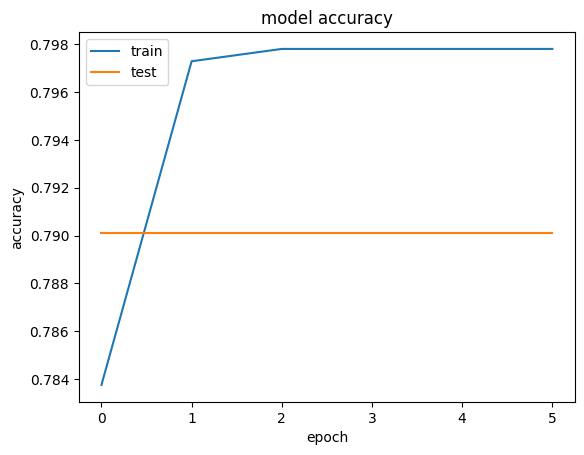

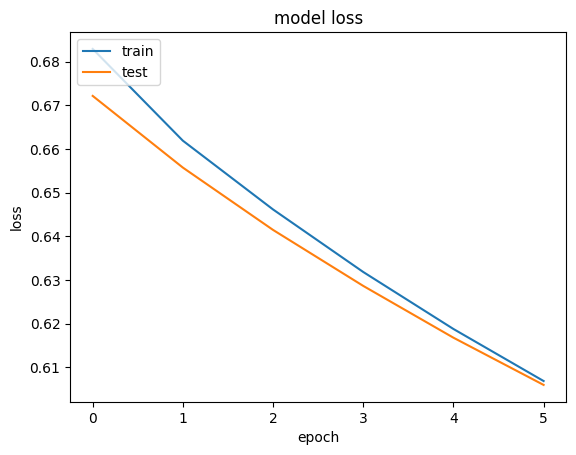

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 100)          913600    
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 977,857
Trainable params: 64,257
Non-trainable params: 913,600
_________________________________________________________________
None


In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
61/61 [==============================] - 2s 12ms/step - loss: 0.6215 - acc: 0.7852 - val_loss: 0.5527 - val_acc: 0.7896
Epoch 2/6
61/61 [==============================] - 0s 6ms/step - loss: 0.5133 - acc: 0.7978 - val_loss: 0.5127 - val_acc: 0.7901
Epoch 3/6
61/61 [==============================] - 0s 6ms/step - loss: 0.5006 - acc: 0.7979 - val_loss: 0.5133 - val_acc: 0.7901
Epoch 4/6
61/61 [==============================] - 0s 7ms/step - loss: 0.5007 - acc: 0.7979 - val_loss: 0.5128 - val_acc: 0.7901
Epoch 5/6
61/61 [==============================] - 0s 6ms/step - loss: 0.5007 - acc: 0.7979 - val_loss: 0.5129 - val_acc: 0.7901
Epoch 6/6
61/61 [==============================] - 0s 6ms/step - loss: 0.5007 - acc: 0.7979 - val_loss: 0.5130 - val_acc: 0.7901


In [ ]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

76/76 [==============================] - 1s 4ms/step - loss: 0.4918 - acc: 0.8069


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4918023645877838
Test Accuracy: 0.8069307208061218


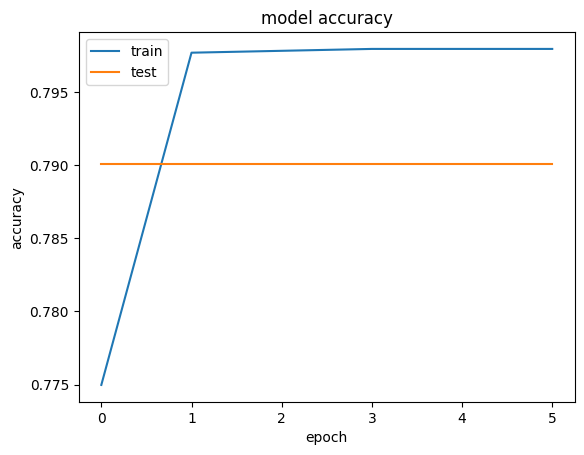

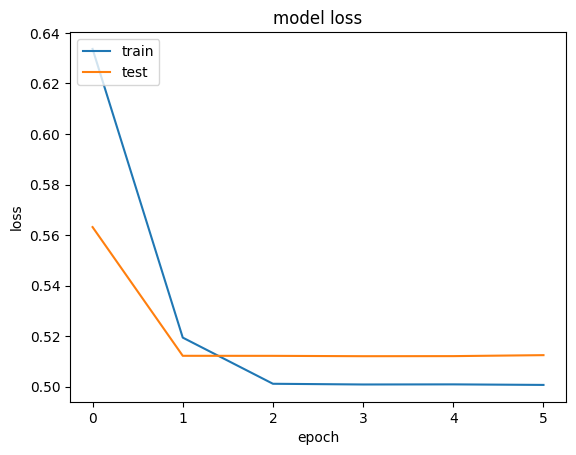

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          913600    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,030,977
Trainable params: 117,377
Non-trainable params: 913,600
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
61/61 [==============================] - 4s 22ms/step - loss: 0.5339 - acc: 0.7835 - val_loss: 0.5162 - val_acc: 0.7886
Epoch 2/6
61/61 [==============================] - 1s 12ms/step - loss: 0.5078 - acc: 0.7955 - val_loss: 0.5186 - val_acc: 0.7886
Epoch 3/6
61/61 [==============================] - 1s 12ms/step - loss: 0.5090 - acc: 0.7954 - val_loss: 0.5253 - val_acc: 0.7886
Epoch 4/6
61/61 [==============================] - 1s 12ms/step - loss: 0.5086 - acc: 0.7951 - val_loss: 0.5166 - val_acc: 0.7886
Epoch 5/6
61/61 [==============================] - 1s 9ms/step - loss: 0.5076 - acc: 0.7954 - val_loss: 0.5166 - val_acc: 0.7886
Epoch 6/6
61/61 [==============================] - 1s 11ms/step - loss: 0.5067 - acc: 0.7956 - val_loss: 0.5178 - val_acc: 0.7886


In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

76/76 [==============================] - 0s 5ms/step - loss: 0.4988 - acc: 0.8045


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4988012909889221
Test Accuracy: 0.8044554591178894


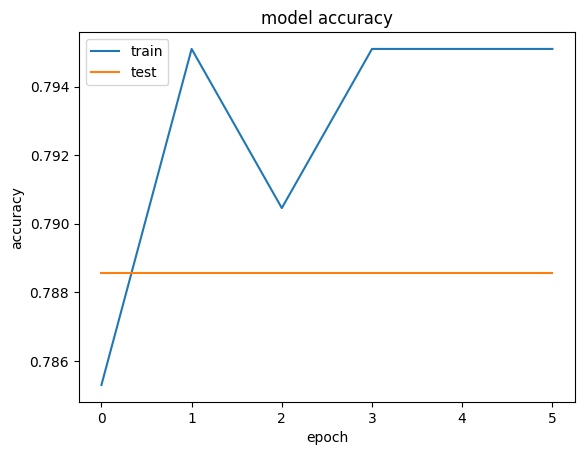

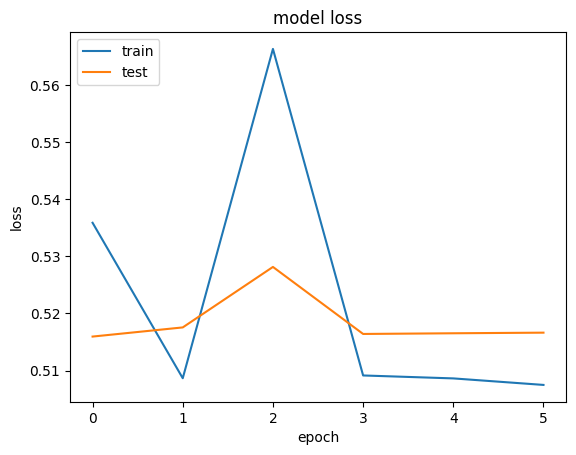

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [ ]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')